<a href="https://colab.research.google.com/github/deburg0/DA_RNN_GENEXP/blob/main/docs/01-pinns/pinns-exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Networks (PINNs)

**Learning Objectives:**
- Understand why standard neural networks fail for physics problems
- Learn how to incorporate physics into neural network training
- Master automatic differentiation for computing derivatives
- Compare data-driven vs physics-informed approaches

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/01-pinns/pinns-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/01-pinns/pinns.ipynb)


**Slides:** [![View PDF](https://img.shields.io/badge/View-PDF-red?style=flat-square&logo=googledocs&logoColor=white)](https://github.com/kks32-courses/sciml/raw/main/docs/01-pinns/pinns-slides.pdf)

## The Problem: A Damped Harmonic Oscillator

We begin with a concrete problem that everyone understands: a mass on a spring with damping. This is the perfect starting point because:

1. **Physical intuition**: Everyone knows how springs work
2. **Mathematical tractability**: We have an exact solution
3. **Clear demonstration**: Shows why standard ML fails and PINNs succeed

### The Physical System

![Harmonic Oscillator](https://github.com/kks32-courses/sciml/blob/main/docs/01-pinns/figs/harmonic-oscillator.png?raw=1)

A mass $m$ attached to a spring (constant $k$) with damping (coefficient $c$). The displacement $u(t)$ from equilibrium satisfies:

$$m \frac{d^2 u}{dt^2} + c \frac{du}{dt} + ku = 0$$

**Initial conditions:** $u(0) = 1$, $\frac{du}{dt}(0) = 0$ (starts at rest, displaced)

**Parameters:** $m = 1$, $c = 4$, $k = 400$ (underdamped: $c^2 < 4mk$)

### The Exact Solution

For underdamped motion ($\delta < \omega_0$ where $\delta = c/(2m)$ and $\omega_0 = \sqrt{k/m}$):

$$u(t) = e^{-\delta t}\left(\cos(\omega t) + \frac{\delta}{\omega}\sin(\omega t)\right)$$

where $\omega = \sqrt{\omega_0^2 - \delta^2}$ is the damped frequency.

> This example is adapted from Ben Moseley's [blog post](https://web.archive.org/web/20240618153956/https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Physical parameters
m = 1.0      # mass
c = 4.0      # damping coefficient
k = 400.0    # spring constant

# Derived parameters
delta = c / (2 * m)                # damping ratio
omega_0 = np.sqrt(k / m)           # natural frequency
omega = np.sqrt(omega_0**2 - delta**2) # damped frequency

print(f"Physical parameters:")
print(f"  δ = {delta:.2f} (damping ratio)")
print(f"  ω₀ = {omega_0:.2f} (natural frequency)")
print(f"  ω = {omega:.2f} (damped frequency)")
print(f"  Underdamped: {delta < omega_0}")

Physical parameters:
  δ = 2.00 (damping ratio)
  ω₀ = 20.00 (natural frequency)
  ω = 19.90 (damped frequency)
  Underdamped: True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def oscillator(d, w0, x):
    """Analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = np.cos(phi + w * x)
    exp = np.exp(-d * x)
    y = exp * 2 * A * cos
    return y

def create_spring_oscillator_animation_inline():
    d = 2  # damping coefficient
    w0 = 20  # natural frequency

    # Animation variables
    totalTime = 1.0  # Time domain [0, 1]
    dt = 0.0075
    t_array = np.arange(0, totalTime, dt)
    y_array = oscillator(d, w0, t_array)

    # Scaling factors
    scale = 1.0
    centerY = 0.0

    # Compute y_min and y_max from the displacement data
    y_min = np.min(y_array * scale + centerY)
    y_max = np.max(y_array * scale + centerY)

    # Create figure and axes
    fig, (ax_trace, ax_spring) = plt.subplots(1, 2, figsize=(12, 4))
    plt.tight_layout(pad=3.0)

    # Plot the displacement curve on ax_trace
    ax_trace.plot(t_array, y_array * scale + centerY, color='gray')
    trace_point, = ax_trace.plot([], [], 'bo', markersize=8)
    ax_trace.set_xlim(0, totalTime)
    ax_trace.set_ylim(-1.1, 1.1)
    ax_trace.set_xlabel('Time (s)')
    ax_trace.set_ylabel('Displacement')
    ax_trace.set_title('Displacement vs. Time')

    # Set up the mass-spring system on ax_spring
    ax_spring.set_xlim(-1, 1)
    ax_spring.set_ylim(-1.1, 1.1)
    ax_spring.axis('off')
    ax_spring.set_title('Mass-Spring System')

    # Draw the fixed block at equilibrium position (y=0)
    ax_spring.plot([-0.2, 0.2], [1.0, 1.0], 'k-', linewidth=4)

    # Initialize the mass and spring
    mass, = ax_spring.plot([], [], 'bo', markersize=20)
    spring_line, = ax_spring.plot([], [], 'k-', linewidth=1.5)

    def get_spring(y_start, y_end, coils=10, points_per_coil=15):
        length = y_end - y_start
        t = np.linspace(0, 1, coils * points_per_coil)
        x = 0.06 * np.sin(2 * np.pi * coils * t)
        y = y_start + length * t
        return x, y

    def update(frame):
        t = t_array[frame % len(t_array)]
        y = oscillator(d, w0, t) * scale + centerY

        # Update trace point
        trace_point.set_data([t], [y])

        # Update mass position
        mass.set_data([0], [y])

        # Update spring
        x_spring, y_spring = get_spring(1.0, y)  # Starting from y=1.0 (fixed point)
        spring_line.set_data(x_spring, y_spring)

        return trace_point, mass, spring_line

    ani = FuncAnimation(fig, update, frames=len(t_array), interval=20, blit=True)

    plt.close(fig)
    return HTML(ani.to_jshtml())

# Call the function to display the animation
create_spring_oscillator_animation_inline()

### Creating Sparse Training Data

In real applications, we don't have the complete solution. We only have **sparse, potentially noisy measurements**. Let's simulate this scenario:

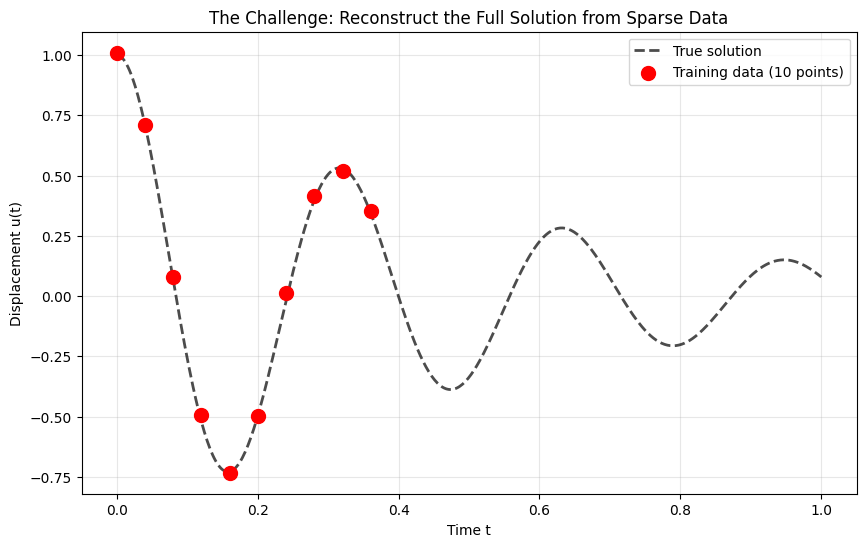

Training data: 10 points with noise level 0.02
Challenge: Can a neural network reconstruct the full solution?


In [3]:
# Generate sparse training data
n_data = 10  # Only 10 data points!

def exact_solution(t):
    """Analytical solution to the damped harmonic oscillator"""
    return np.exp(-delta * t) * (np.cos(omega * t) + (delta/omega) * np.sin(omega * t))

# Get solution
t_data = np.linspace(0, 0.3607, n_data)
u_data = exact_solution(t_data)

# Exact solution
t_exact = np.linspace(0, 1, 500)
u_exact = exact_solution(t_exact)


# Add some noise to make it realistic
noise_level = 0.02
u_data_noisy = u_data + noise_level * np.random.normal(0, 1, len(u_data))

# Visualize the sparse data
plt.figure(figsize=(10, 6))
plt.plot(t_exact, u_exact, 'k--', linewidth=2, alpha=0.7, label='True solution')
plt.scatter(t_data, u_data_noisy, color='red', s=100, zorder=5, label=f'Training data ({n_data} points)')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.title('The Challenge: Reconstruct the Full Solution from Sparse Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training data: {n_data} points with noise level {noise_level}")
print("Challenge: Can a neural network reconstruct the full solution?")

In [4]:
def exact_velocity(t):
    """
    First derivative of the exact solution: du/dt

    Given: u(t) = e^(-δt) * [cos(ωt) + (δ/ω)sin(ωt)]

    Using product rule: d/dt[f(t)g(t)] = f'(t)g(t) + f(t)g'(t)
    where f(t) = e^(-δt) and g(t) = cos(ωt) + (δ/ω)sin(ωt)
    """
    exp_term = np.exp(-delta * t)
    cos_term = np.cos(omega * t)
    sin_term = np.sin(omega * t)

    # Derivative of exponential term: d/dt[e^(-δt)] = -δe^(-δt)
    d_exp_term = -delta * exp_term

    # Derivative of trigonometric term: d/dt[cos(ωt) + (δ/ω)sin(ωt)]
    d_trig_term = -omega * sin_term + (delta/omega) * omega * cos_term
    d_trig_term = -omega * sin_term + delta * cos_term

    # Apply product rule
    velocity = d_exp_term * (cos_term + (delta/omega) * sin_term) + exp_term * d_trig_term

    return velocity

def exact_acceleration(t):
    """
    Second derivative of the exact solution: d²u/dt²

    This can be computed by differentiating the velocity function,
    or directly from the ODE: d²u/dt² = -(c/m)(du/dt) - (k/m)u

    Using the ODE relation is more numerically stable:
    m * d²u/dt² + c * du/dt + k * u = 0
    Therefore: d²u/dt² = -(c/m) * du/dt - (k/m) * u
    """
    u = exact_solution(t)
    du_dt = exact_velocity(t)

    # From the ODE: m * d²u/dt² = -c * du/dt - k * u
    d2u_dt2 = -(c/m) * du_dt - (k/m) * u

    return d2u_dt2

## Stage 1: The Data-Only Approach (Why It Fails)

**The Natural First Attempt:** Train a neural network to fit the sparse data points.

### Neural Network Architecture

![Standard Neural Network](https://github.com/kks32-courses/sciml/blob/main/docs/01-pinns/figs/oscillator-nn.png?raw=1)

A simple feedforward network:
- **Input:** Time $t$
- **Hidden layers:** Dense layers with activation functions
- **Output:** Predicted displacement $\hat{u}_\theta(t)$

**Loss function:** Mean squared error between predictions and data
$$\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N} \sum_{i=1}^N |\hat{u}_\theta(t_i) - u_i|^2$$

**Training:** Standard gradient descent to minimize $\mathcal{L}_{\text{data}}$

## Theoretical Foundation: Universal Approximation Theorem

Before we dive into implementation, we need to understand **why** neural networks can solve differential equations. The answer lies in the Universal Approximation Theorem and its extension to **Sobolev spaces**.

### Classical Universal Approximation Theorem

As we learned in the MLP module, the classical UAT tells us that feedforward networks can approximate continuous functions:

**Theorem (Cybenko, 1989):** Let $\sigma$ be a continuous, non-constant, and bounded activation function. Then finite sums of the form:
$$F(x) = \sum_{j=1}^N c_j \sigma(w_j \cdot x + b_j)$$
are dense in $C(K)$ for any compact set $K \subset \mathbb{R}^d$.

**Translation:** Given enough neurons, neural networks can approximate any continuous function arbitrarily well.

### Extension to Sobolev Spaces: The Key for PDEs

**But here's the critical insight:** For differential equations, we don't just need to approximate functions—we need to approximate **functions and their derivatives simultaneously**.

This is where **Sobolev spaces** become essential.

**Definition (Sobolev Space $H^k(\Omega)$):** The space of functions whose weak derivatives up to order $k$ are square-integrable:
$$H^k(\Omega) = \left\{ u : \Omega \to \mathbb{R} \,:\, \sum_{|\alpha| \leq k} \|D^\alpha u\|_{L^2(\Omega)}^2 < \infty \right\}$$

where $D^\alpha u$ denotes the weak derivative of multi-index $\alpha$ with $|\alpha| = \alpha_1 + \alpha_2 + \cdots + \alpha_d$.

**Extended Universal Approximation Theorem:** Neural networks with sufficiently smooth activation functions can approximate functions in Sobolev spaces $H^k(\Omega)$.

**Mathematical Statement:** Let $\sigma \in C^k(\mathbb{R})$ (i.e., $\sigma$ is $k$ times continuously differentiable). Then for any $u \in H^k(\Omega)$ and $\epsilon > 0$, there exists a neural network $\hat{u}_\theta$ such that:
$$\|u - \hat{u}_\theta\|_{H^k} < \epsilon$$

where the Sobolev norm is:
$$\|u\|_{H^k}^2 = \sum_{|\alpha| \leq k} \|D^\alpha u\|_{L^2}^2$$

### Why This Matters for PINNs

**Critical Connection:** When we solve a differential equation of order $k$, we need:

1. **Function approximation:** $\hat{u}_\theta(x) \approx u(x)$
2. **Derivative approximation:** $\frac{\partial^j \hat{u}_\theta}{\partial x^j} \approx \frac{\partial^j u}{\partial x^j}$ for $j = 1, 2, \ldots, k$

The extended UAT guarantees this is possible provided:
- **Activation function smoothness:** $\sigma \in C^k$ (at least $k$ times differentiable)
- **Sufficient network capacity:** Enough neurons and layers

**For our oscillator ODE:** $m\frac{d^2u}{dt^2} + c\frac{du}{dt} + ku = 0$
- We need $k = 2$ (second-order equation)
- Activation function must be $C^2$ (twice differentiable)
- $\tanh$, $\sin$, Swish ✓ | ReLU ✗

**The Magic:** Automatic differentiation + UAT in Sobolev spaces = neural networks that can learn solutions to differential equations!"

In [5]:
class SimpleNN(nn.Module):
    """Standard feedforward neural network"""
    def __init__(self, hidden_size=32, n_layers=3):
        super().__init__()

        layers = []
        layers.append(nn.Linear(1, hidden_size))  # Input: time t

        # Hidden layers
        for _ in range(n_layers):
            layers.append(nn.Tanh())  # Smooth activation (important!)
            layers.append(nn.Linear(hidden_size, hidden_size))

        layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))  # Output: displacement u

        self.network = nn.Sequential(*layers)

    def forward(self, t):
        return self.network(t)

# Convert data to PyTorch tensors
t_data_tensor = torch.tensor(t_data.reshape(-1, 1), dtype=torch.float32)
u_data_tensor = torch.tensor(u_data_noisy.reshape(-1, 1), dtype=torch.float32)
t_test_tensor = torch.tensor(t_exact.reshape(-1, 1), dtype=torch.float32)

print("Data shapes:")
print(f"  Training: {t_data_tensor.shape} -> {u_data_tensor.shape}")
print(f"  Testing: {t_test_tensor.shape}")

Data shapes:
  Training: torch.Size([10, 1]) -> torch.Size([10, 1])
  Testing: torch.Size([500, 1])


### Training the Standard Neural Network

**What we expect:** The network should learn to pass through the data points.

**What we hope:** It will interpolate smoothly between points.

**What actually happens:** Let's find out!

In [6]:
def train_standard_nn(model, t_data, u_data, epochs=5000, lr=1e-3):
    """Train a standard neural network on data only"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    # Training loop
    pbar = tqdm(range(epochs), desc="Training Standard NN")
    for epoch in pbar:
        optimizer.zero_grad()
        # Forward pass
        u_pred = model(t_data)
        # Data loss only
        loss = criterion(u_pred, u_data)
        # Backward pass
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Update progress bar with loss information every 100 epochs
        if (epoch + 1) % 100 == 0:
            pbar.set_postfix({'Loss': f'{loss.item():.6f}'})

    return losses

# Create and train the standard neural network
standard_nn = SimpleNN()
losses_standard = train_standard_nn(standard_nn, t_data_tensor, u_data_tensor)
print(f"Final training loss: {losses_standard[-1]:.2e}")

Training Standard NN: 100%|██████████| 5000/5000 [00:08<00:00, 601.13it/s, Loss=0.000000]

Final training loss: 2.81e-07


### The Failure of the Data-Only Approach

**Critical Question:** How well does it predict the full solution?

![Standard NN Result](https://github.com/kks32-courses/sciml/blob/main/docs/01-pinns/figs/oscillator-result-nn.png?raw=1)

**What we observe:** The network fits the training points but fails catastrophically between them.

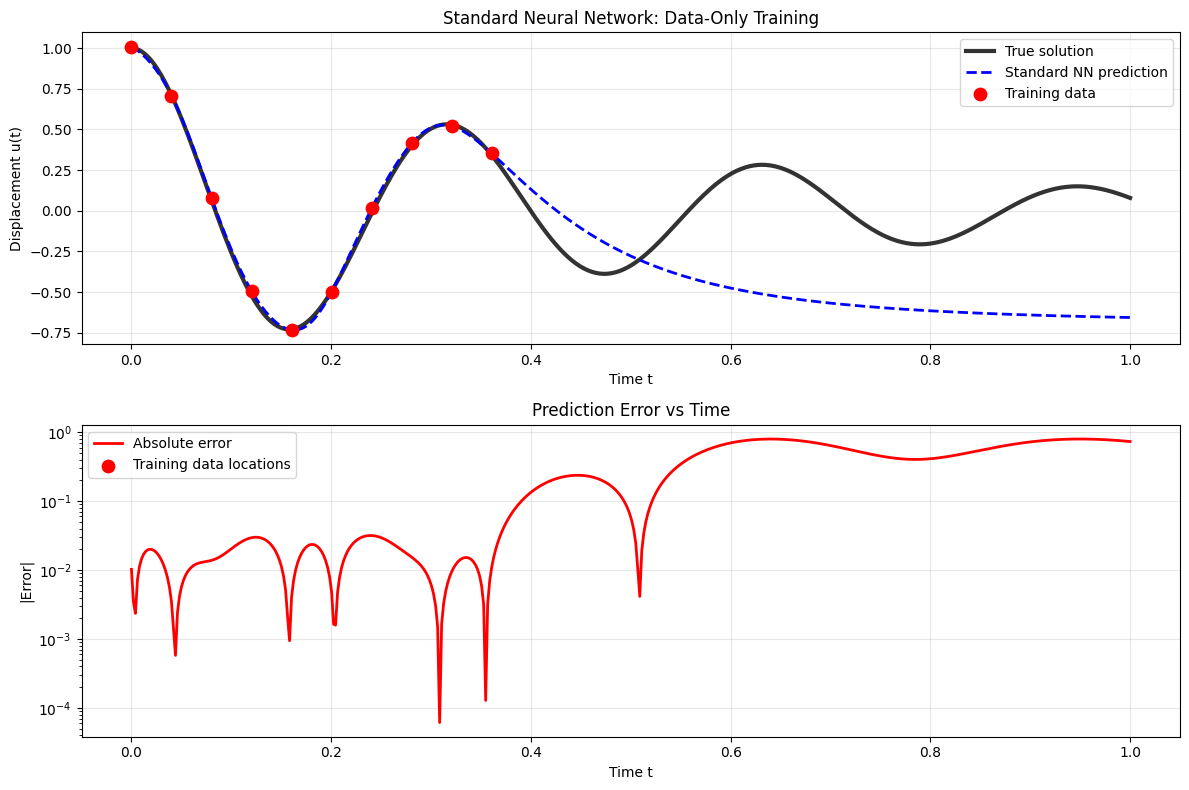

 Standard NN Performance:
  MSE: 0.193223
  Max Error: 0.799799


In [7]:
# Make predictions on the full time domain
with torch.no_grad():
    u_pred_standard = standard_nn(t_test_tensor).numpy().flatten()

# Visualize the results
plt.figure(figsize=(12, 8))

# Plot 1: Full comparison
plt.subplot(2, 1, 1)
plt.plot(t_exact, u_exact, 'k-', linewidth=3, label='True solution', alpha=0.8)
plt.plot(t_exact, u_pred_standard, 'b--', linewidth=2, label='Standard NN prediction')
plt.scatter(t_data, u_data_noisy, color='red', s=80, zorder=5, label='Training data')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.title('Standard Neural Network: Data-Only Training')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error analysis
plt.subplot(2, 1, 2)
error = np.abs(u_pred_standard - u_exact)
plt.plot(t_exact, error, 'r-', linewidth=2, label='Absolute error')
plt.scatter(t_data, np.zeros_like(t_data), color='red', s=80, zorder=5,
            label='Training data locations')
plt.xlabel('Time t')
plt.ylabel('|Error|')
plt.title('Prediction Error vs Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

# Compute metrics
mse = np.mean((u_pred_standard - u_exact)**2)
max_error = np.max(np.abs(u_pred_standard - u_exact))

print(f" Standard NN Performance:")
print(f"  MSE: {mse:.6f}")
print(f"  Max Error: {max_error:.6f}")

## Stage 2: Enter Physics-Informed Neural Networks

**The Key Insight:** Instead of just fitting data, enforce the differential equation!

### The PINN Architecture

![PINN Architecture](https://github.com/kks32-courses/sciml/blob/main/docs/01-pinns/figs/oscillator-pinn-nn.png?raw=1)

**Same network, different loss function:**
- Network still predicts $\hat{u}_\theta(t)$
- But now we compute derivatives via **automatic differentiation**
- Physics residual: $\mathcal{R}_\theta(t) = m\frac{d^2\hat{u}_\theta}{dt^2} + c\frac{d\hat{u}_\theta}{dt} + k\hat{u}_\theta$

### The Physics Residual

**Mathematical Foundation:** If $\hat{u}_\theta(t)$ is the exact solution, then:
$$m\frac{d^2\hat{u}_\theta}{dt^2} + c\frac{d\hat{u}_\theta}{dt} + k\hat{u}_\theta = 0$$

**PINN Strategy:** Make this residual as small as possible everywhere in the domain.

**Collocation Points:** We evaluate the residual at many points \{t_j\} throughout $[0,1]$, not just at data points.

### The Complete PINN Loss Function

$$\mathcal{L}_{\text{total}}(\theta) = \mathcal{L}_{\text{data}}(\theta) + \lambda \mathcal{L}_{\text{physics}}(\theta)$$

where:

**Data Loss:** $\mathcal{L}_{\text{data}}(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} |\hat{u}_\theta(t_i) - u_i|^2$

**Physics Loss:** $\mathcal{L}_{\text{physics}}(\theta) = \frac{1}{N_{\text{colloc}}} \sum_{j=1}^{N_{\text{colloc}}} |\mathcal{R}_\theta(t_j)|^2$

**Balance Parameter:** $\lambda$ controls data vs physics trade-off

### Automatic Differentiation: The Secret Weapon

**Critical Question:** How do we compute $\frac{d\hat{u}_\theta}{dt}$ and $\frac{d^2\hat{u}_\theta}{dt^2}$?

**Answer:** Automatic differentiation (AD) gives us **exact** derivatives!

- No finite differences
- No numerical errors
- Computed via chain rule through the computational graph
- Available in PyTorch, TensorFlow, JAX

### Demonstration: Automatic Differentiation in Action

Let's see how automatic differentiation works in PyTorch:

In [8]:
def compute_derivatives_demo():
    """Demonstrate automatic differentiation"""
    # Create a simple test case: u(t) = sin(t)
    t = torch.tensor([0.5], requires_grad=True)  # Enable gradient computation
    u = torch.sin(t)  # u = sin(t)

    print("Function: u(t) = sin(t)")
    print(f"At t = {t.item():.2f}:")
    print(f"  u = {u.item():.6f}")

    # First derivative: du/dt


    print(f"  du/dt = {du_dt.item():.6f} (exact: cos({t.item():.2f}) = {np.cos(t.item()):.6f})")

    # Second derivative: d²u/dt²


    print(f"  d²u/dt² = {d2u_dt2.item():.6f} (exact: -sin({t.item():.2f}) = {-np.sin(t.item()):.6f})")

    print("✅ Automatic differentiation gives exact derivatives!")

compute_derivatives_demo()

Function: u(t) = sin(t)
At t = 0.50:
  u = 0.479426


NameError: name 'du_dt' is not defined

## Stage 3: PINN Implementation

**Now the real work begins!** Let's implement a Physics-Informed Neural Network step by step.

### Step 1: Physics Loss Function

The heart of PINN is computing the physics residual using automatic differentiation:

In [ ]:
def physics_loss(model, t_colloc, m, c, k):
    """
    Compute the physics loss for the damped harmonic oscillator

    ODE: m * d²u/dt² + c * du/dt + k * u = 0
    """
    # Ensure gradients are enabled for input
    t_colloc = t_colloc.clone().detach().requires_grad_(True)

    # Forward pass: compute u(t)
    u = model(t_colloc)

    # First derivative: du/dt
    du_dt = torch.autograd.grad(
        outputs=u,
        inputs=t_colloc,
        grad_outputs=torch.ones_like(u),
        create_graph=True,  # Allow higher-order derivatives
        retain_graph=True
    )[0]

    # Second derivative: d²u/dt²
    d2u_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t_colloc,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
    )[0]

    # Physics residual: R = m * d²u/dt² + c * du/dt + k * u



    # Mean squared residual
    physics_loss = torch.mean(residual**2)

    return physics_loss

# Test the physics loss function
test_model = SimpleNN()
t_test_colloc = torch.linspace(0, 1, 50).reshape(-1, 1)
test_loss = physics_loss(test_model, t_test_colloc, m, c, k)

print(f"Physics loss (untrained model): {test_loss.item():.6f}")
print("This is large since the model hasn't learned the physics yet!")

### Step 2: Complete PINN Training Loop

**Key Components:**
1. **Data loss:** Fit the sparse measurements
2. **Physics loss:** Satisfy the differential equation
3. **Collocation points:** Where we enforce physics (not necessarily data points)
4. **Balance parameter $\lambda$:** Controls the trade-off

In [ ]:
def train_pinn(model, t_data, u_data, t_colloc, m, c, k,
               epochs=10000, lr=1e-3, lambda_physics=1e-4):
    """
    Train a Physics-Informed Neural Network

    Args:
        model: Neural network
        t_data, u_data: Training data points
        t_colloc: Collocation points for physics
        m, c, k: Physical parameters
        lambda_physics: Balance parameter between data and physics
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Storage for loss history
    data_losses = []
    physics_losses = []
    total_losses = []

    print(f"Training PINN with λ = {lambda_physics}")
    print(f"Data points: {len(t_data)}, Collocation points: {len(t_colloc)}")

    pbar = tqdm(range(epochs), desc="Training PINN")
    for epoch in pbar:
        optimizer.zero_grad()

        # Data loss: how well do we fit the measurements?
        u_pred_data = model(t_data)
        loss_data = criterion(u_pred_data, u_data)

        # Physics loss: how well do we satisfy the ODE?
        loss_physics = physics_loss(model, t_colloc, m, c, k)

        # Total loss: balance data fitting and physics
        total_loss = loss_data + lambda_physics * loss_physics

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Store losses
        data_losses.append(loss_data.item())
        physics_losses.append(loss_physics.item())
        total_losses.append(total_loss.item())

        if (epoch + 1) % 2000 == 0:
            pbar.set_postfix({'Loss': f'{loss_data.item():.6f}',
                              'Physics': f'{loss_physics.item():.6f}',
                              'Total': f'{total_loss.item():.6f}'})

    return data_losses, physics_losses, total_losses

# Setup for PINN training
n_colloc = 200  # Number of collocation points
t_colloc = torch.linspace(0, 1, n_colloc).reshape(-1, 1)
lambda_physics = 1e-4  # Balance parameter

print(f"Collocation points: uniformly distributed in [0, 1]")
print(f"Physics weight λ = {lambda_physics} (typically much smaller than 1)")

# Visualize training setup
plt.figure(figsize=(10, 4))
plt.scatter(t_data, u_data_noisy, color='red', s=100, zorder=5, label='Data points (fit these)')
plt.scatter(t_colloc.numpy().flatten()[::10], np.zeros(len(t_colloc[::10])),
            color='green', marker='^', s=60, alpha=0.7, label='Collocation points (enforce physics)')
plt.plot(t_exact, u_exact, 'k--', alpha=0.7, label='True solution')
plt.xlabel('Time t')
plt.ylabel('Displacement')
plt.title('PINN Training Setup: Data Points vs Collocation Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 3: Train the PINN

**The moment of truth!** Let's train the PINN and see if it can learn both the data and the physics:

In [ ]:
# Create a fresh PINN model
pinn_model = SimpleNN()

# Train the PINN
data_losses, physics_losses, total_losses = train_pinn(
    pinn_model, t_data_tensor, u_data_tensor, t_colloc, m, c, k, epochs=20000
)

# Make predictions
with torch.no_grad():
    u_pred_pinn = pinn_model(t_test_tensor).numpy().flatten()

print(f"PINN Training Complete!")
print(f"Final data loss: {data_losses[-1]:.6f}")
print(f"Final physics loss: {physics_losses[-1]:.6f}")

## Stage 4: The Moment of Truth - Comparing Results

### Direct Comparison: Standard NN vs PINN

![PINN Result](https://github.com/kks32-courses/sciml/blob/main/docs/01-pinns/figs/oscillator-result-pinn.png?raw=1)

**What we expect to see:**
- **Standard NN:** Fits data points but fails between them
- **PINN:** Fits data points AND follows physics everywhere

In [ ]:
# Compare Standard NN vs PINN
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Solutions comparison
ax = axes[0, 0]
ax.plot(t_exact, u_exact, 'k-', linewidth=3, label='True solution', alpha=0.8)
ax.plot(t_exact, u_pred_standard, 'b--', linewidth=2, label='Standard NN', alpha=0.8)
ax.plot(t_exact, u_pred_pinn, 'r-', linewidth=2, label='PINN', alpha=0.8)
ax.scatter(t_data, u_data_noisy, color='red', s=80, zorder=5, label='Training data')
ax.set_xlabel('Time t')
ax.set_ylabel('Displacement u(t)')
ax.set_title('Solution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Error comparison
ax = axes[0, 1]
error_standard = np.abs(u_pred_standard - u_exact)
error_pinn = np.abs(u_pred_pinn - u_exact)
ax.plot(t_exact, error_standard, 'b-', linewidth=2, label='Standard NN error')
ax.plot(t_exact, error_pinn, 'r-', linewidth=2, label='PINN error')
ax.set_xlabel('Time t')
ax.set_ylabel('Absolute Error')
ax.set_title('Error Comparison')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Loss evolution for Standard NN
ax = axes[1, 0]
ax.plot(losses_standard, 'b-', linewidth=2, label='Data loss only')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Standard NN Training')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Loss evolution for PINN
ax = axes[1, 1]
ax.plot(data_losses, 'b-', linewidth=2, label='Data loss', alpha=0.8)
ax.plot(physics_losses, 'g-', linewidth=2, label='Physics loss', alpha=0.8)
ax.plot(total_losses, 'r-', linewidth=2, label='Total loss', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('PINN Training (Multiple Loss Components)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative comparison
mse_standard = np.mean((u_pred_standard - u_exact)**2)
mse_pinn = np.mean((u_pred_pinn - u_exact)**2)
max_error_standard = np.max(np.abs(u_pred_standard - u_exact))
max_error_pinn = np.max(np.abs(u_pred_pinn - u_exact))

print("📊 QUANTITATIVE COMPARISON")
print("="*50)
print(f"{'Metric':<20} {'Standard NN':<15} {'PINN':<15} {'Improvement':<15}")
print("-"*65)
print(f"{'MSE':<20} {mse_standard:<15.6f} {mse_pinn:<15.6f} {mse_standard/mse_pinn:<15.1f}x")
print(f"{'Max Error':<20} {max_error_standard:<15.6f} {max_error_pinn:<15.6f} {max_error_standard/max_error_pinn:<15.1f}x")

print(f"✅ PINN is {mse_standard/mse_pinn:.0f}x more accurate!")

### Phase Portrait Analysis: The Ultimate Physics Test

**Physical Insight:** For a harmonic oscillator, the phase portrait (velocity vs displacement) reveals the underlying dynamics. Real oscillators trace smooth spirals in phase space as energy dissipates.

**Critical Test:** Can our neural networks capture this fundamental physical behavior?"

In [ ]:
def compute_model_derivatives(model, t_tensor):
    """Compute derivatives of the model using automatic differentiation"""
    t_tensor = t_tensor.clone().detach().requires_grad_(True)

    # Function value
    u = model(t_tensor)

    # First derivative
    du_dt = torch.autograd.grad(u, t_tensor, grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True)[0]

    # Second derivative
    d2u_dt2 = torch.autograd.grad(du_dt, t_tensor, grad_outputs=torch.ones_like(du_dt),
                                 create_graph=True, retain_graph=True)[0]

    return u.detach().numpy(), du_dt.detach().numpy(), d2u_dt2.detach().numpy()

# Compute derivatives for both models
# REMOVED torch.no_grad() context - this was causing the error
# Standard NN derivatives
u_std, du_dt_std, d2u_dt2_std = compute_model_derivatives(standard_nn, t_test_tensor)

# PINN derivatives
u_pinn, du_dt_pinn, d2u_dt2_pinn = compute_model_derivatives(pinn_model, t_test_tensor)

# Analytical derivatives for comparison
v_exact = exact_velocity(t_exact)
a_exact = exact_acceleration(t_exact)

# Plot derivative comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Displacement
ax = axes[0]
ax.plot(t_exact, u_exact, 'k-', linewidth=3, label='Exact')
ax.plot(t_exact, u_std.flatten(), 'b--', linewidth=2, label='Standard NN', alpha=0.8)
ax.plot(t_exact, u_pinn.flatten(), 'r-', linewidth=2, label='PINN', alpha=0.8)
ax.scatter(t_data, u_data_noisy, color='red', s=60, zorder=5, alpha=0.8)
ax.set_ylabel('Displacement u(t)')
ax.set_title('Function and Derivatives: Standard NN vs PINN')
ax.legend()
ax.grid(True, alpha=0.3)

# First derivative (velocity)
ax = axes[1]
ax.plot(t_exact, v_exact, 'k-', linewidth=3, label='Exact du/dt')
ax.plot(t_exact, du_dt_std.flatten(), 'b--', linewidth=2, label='Standard NN du/dt', alpha=0.8)
ax.plot(t_exact, du_dt_pinn.flatten(), 'r-', linewidth=2, label='PINN du/dt', alpha=0.8)
ax.set_ylabel('Velocity du/dt')
ax.legend()
ax.grid(True, alpha=0.3)

# Second derivative (acceleration)
ax = axes[2]
ax.plot(t_exact, a_exact, 'k-', linewidth=3, label='Exact d²u/dt²')
ax.plot(t_exact, d2u_dt2_std.flatten(), 'b--', linewidth=2, label='Standard NN d²u/dt²', alpha=0.8)
ax.plot(t_exact, d2u_dt2_pinn.flatten(), 'r-', linewidth=2, label='PINN d²u/dt²', alpha=0.8)
ax.set_ylabel('Acceleration d²u/dt²')
ax.set_xlabel('Time t')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Derivative errors
print("📈 DERIVATIVE ACCURACY")
print("="*40)

velocity_error_std = np.mean((du_dt_std.flatten() - v_exact)**2)
velocity_error_pinn = np.mean((du_dt_pinn.flatten() - v_exact)**2)
accel_error_std = np.mean((d2u_dt2_std.flatten() - a_exact)**2)
accel_error_pinn = np.mean((d2u_dt2_pinn.flatten() - a_exact)**2)

print(f"Velocity MSE (du/dt):")
print(f"  Standard NN: {velocity_error_std:.6f}")
print(f"  PINN: {velocity_error_pinn:.6f}")
print(f"  Improvement: {velocity_error_std/velocity_error_pinn:.1f}x")

print(f"Acceleration MSE (d²u/dt²):")
print(f"  Standard NN: {accel_error_std:.6f}")
print(f"  PINN: {accel_error_pinn:.6f}")
print(f"  Improvement: {accel_error_std/accel_error_pinn:.1f}x")

### Deep Dive: Derivative Analysis

**Critical Test:** Can the PINN learn physically consistent derivatives?

Since we enforce the ODE through derivatives, the PINN should naturally learn correct $\frac{du}{dt}$ and $\frac{d^2u}{dt^2}$.

In [ ]:
# Analytical derivatives for comparison
t_exact = np.linspace(0, 1, 500)
v_exact = exact_velocity(t_exact)
a_exact = exact_acceleration(t_exact)

# Phase Portrait Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Phase Portrait
ax1.plot(u_exact, v_exact, 'k-', linewidth=3, label='Exact phase portrait', alpha=0.8)
ax1.plot(u_std.flatten(), du_dt_std.flatten(), 'b--', linewidth=2, label='Standard NN', alpha=0.8)
ax1.plot(u_pinn.flatten(), du_dt_pinn.flatten(), 'r-', linewidth=2, label='PINN', alpha=0.8)

# Mark start and end points
ax1.scatter(u_exact[0], v_exact[0], color='green', s=100, marker='o', zorder=5, label='Start (t=0)')
ax1.scatter(u_exact[-1], v_exact[-1], color='red', s=100, marker='X', zorder=5, label='End (t=1)')

ax1.set_xlabel('Displacement u(t)')
ax1.set_ylabel('Velocity du/dt')
ax1.set_title('Phase Portrait: du/dt vs u(t)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='black', linewidth=0.5)

# Plot 2: Energy Analysis
# Total energy E = (1/2)m*v² + (1/2)k*u² for undamped case
# For damped oscillator, energy should decrease monotonically
energy_exact = 0.5 * m * v_exact**2 + 0.5 * k * u_exact**2
energy_std = 0.5 * m * du_dt_std.flatten()**2 + 0.5 * k * u_std.flatten()**2
energy_pinn = 0.5 * m * du_dt_pinn.flatten()**2 + 0.5 * k * u_pinn.flatten()**2

ax2.plot(t_exact, energy_exact, 'k-', linewidth=3, label='Exact energy', alpha=0.8)
ax2.plot(t_exact, energy_std, 'b--', linewidth=2, label='Standard NN energy', alpha=0.8)
ax2.plot(t_exact, energy_pinn, 'r-', linewidth=2, label='PINN energy', alpha=0.8)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Total Energy E(t)')
ax2.set_title('Energy Dissipation Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## Summary: Why PINNs Work

### The Revolutionary Insight

**Traditional ML:** Learn patterns from data alone

**PINNs:** Learn patterns from data AND physics simultaneously

### Key Advantages of PINNs

1. **Regularization Effect:** Physics constraints prevent overfitting
    - Standard NN can fit any function through the data points
    - PINN is constrained to solutions that satisfy the ODE

2. **Better Interpolation:** Smooth, physically meaningful predictions between data points
    - Standard NN: arbitrary interpolation
    - PINN: physics-guided interpolation

3. **Accurate Derivatives:** Natural consequence of physics enforcement
    - Automatic differentiation + physics loss = correct derivatives
    - Critical for applications requiring gradients (optimization, control)

4. **Data Efficiency:** Less training data needed
    - Physics provides strong inductive bias
    - Can generalize from very sparse measurements

### The Universal Approximation Foundation

**Why this works theoretically:**
- Neural networks can approximate functions in Sobolev spaces $H^k$
- Sobolev spaces include both functions AND their derivatives
- With smooth activation functions ($\tanh$, $\sin$), we can approximate solutions to differential equations
- Automatic differentiation makes this practical

### When to Use PINNs

**Ideal scenarios:**
- ✅ Known governing equations (PDEs/ODEs)
- ✅ Sparse, noisy data
- ✅ Need physically consistent solutions
- ✅ Require accurate derivatives
- ✅ Complex geometries (where finite elements struggle)

**Limitations:**
- ❌ Unknown physics
- ❌ Highly nonlinear/chaotic systems
- ❌ Large-scale problems (computational cost)
- ❌ Discontinuous solutions

### Extensions and Applications

**This framework extends to:**
- **Partial Differential Equations:** Heat equation, wave equation, Navier-Stokes
- **Inverse Problems:** Estimate unknown parameters from data
- **Multi-physics:** Coupled systems (fluid-structure interaction)
- **High Dimensions:** Curse of dimensionality breaking

### The Bottom Line

**PINNs = Universal Function Approximation + Physics Constraints + Automatic Differentiation**

This combination creates a powerful method for solving differential equations with neural networks, particularly when data is sparse and physics is well-understood.

---

**Next Steps:** Try this approach on the 1D Poisson equation with hard constraints!